In [1]:
import numpy as np
import xroms
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import sys
import xrft
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from dask.diagnostics import ProgressBar
import dask
# dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.distributed import Client, LocalCluster

import scipy.integrate as integ
warnings.filterwarnings("ignore")

import seawater as sw
import matplotlib.gridspec as gridspec


In [2]:
def ogive(deltaf,G):
    '''
    ogive(deltaf,G): use very simple integration to calculate the ogive 
    from a spectrum G with data sampled at frequency deltaf.
    2017-01-10T09:40:31 going back to a single frequency for Os and Gs
    '''
    M1 = len(G)
    Og = np.zeros(M1,float)
    Og[0:M1] = np.cumsum(np.flipud(G[0:M1]))
    Og *= deltaf
    Og = np.flipud(Og)
    return Og



In [3]:
# client = Client(n_workers=90)
# # client = Client(cluster)

client = Client(n_workers=30,processes=True)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 30
Total threads: 150,Total memory: 502.98 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34803,Workers: 30
Dashboard: http://127.0.0.1:8787/status,Total threads: 150
Started: Just now,Total memory: 502.98 GiB
Comm: tcp://127.0.0.1:41549,Total threads: 5
Dashboard: http://127.0.0.1:34377/status,Memory: 16.77 GiB
Nanny: tcp://127.0.0.1:41535,


## Reading CROCO (3D)

In [4]:
# chunks={'time_counter':1}

full_path=glob('/data/pacific/lrenault/SASI/FULL/WRF/wrf_3D_Y2012M*.nc')[::2][:-1]
smth_path=glob('/data/pacific/lrenault/SASI/SMTH/WRF/wrf_3D_Y2012M*.nc')[::2][:-1]


varf=xr.open_mfdataset(full_path,data_vars='minimal')
vart=xr.open_mfdataset(smth_path,data_vars='minimal')



# varf=xr.open_mfdataset('/data/pacific/lrenault/SASI/FULL/WRF/wrf_3D_Y2012M06.nc',data_vars='minimal')
# vart=xr.open_mfdataset('/data/pacific/lrenault/SASI/SMTH/WRF/wrf_3D_Y2012M06.nc',data_vars='minimal')



In [5]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [6]:
timer_h=pd.DatetimeIndex(vart.time_counter)
timer_d=pd.DatetimeIndex(vart.time_counter.groupby("time_counter.dayofyear").mean())

# Loading data

In [7]:
rho_air=1.25
c_d=1e-3

In [8]:
%%time
u_full_time=varf.UOCE[:,10:-10,10:-90].compute()
v_full_time=varf.VOCE[:,10:-10,10:-90].compute()

CPU times: user 860 ms, sys: 1.62 s, total: 2.48 s
Wall time: 5.58 s


In [9]:
%%time
u_smth_time=vart.UOCE[:,10:-10,10:-90].compute()
v_smth_time=vart.VOCE[:,10:-10,10:-90].compute()

CPU times: user 673 ms, sys: 1.62 s, total: 2.29 s
Wall time: 3.65 s


In [10]:
%%time
uwind_full_time=varf.U10[:,10:-10,10:-90].compute()
vwind_full_time=varf.V10[:,10:-10,10:-90].compute()

uwind_smth_time=vart.U10[:,10:-10,10:-90].compute()
vwind_smth_time=vart.V10[:,10:-10,10:-90].compute()

CPU times: user 1.36 s, sys: 3.02 s, total: 4.38 s
Wall time: 5.39 s


In [11]:
U_ref_speed_full=np.sqrt((uwind_full_time-u_full_time)**2+(vwind_full_time-v_full_time)**2)
U_ref_speed_smth=np.sqrt((uwind_smth_time-u_smth_time)**2+(vwind_smth_time-v_smth_time)**2)


taux_full=(rho_air*c_d)*(U_ref_speed_full)*(uwind_full_time-u_full_time)
tauy_full=(rho_air*c_d)*(U_ref_speed_full)*(uwind_full_time-u_full_time)


taux_smth=(rho_air*c_d)*(U_ref_speed_smth)*(uwind_smth_time-u_smth_time)
tauy_smth=(rho_air*c_d)*(U_ref_speed_smth)*(uwind_smth_time-u_smth_time)

In [12]:
nf=4
dxx=2000
sclstr='density'
wdws='hann' #'flattop','hann'
wdw_cor=True
phase_bol=True
truncate_bol=True

### Windwork

In [ ]:
tau_u_full_spec=xrft.cross_spectrum(taux_full.drop(['nav_lat', 'nav_lon','time_centered']),
                    u_full_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

tau_v_full_spec=xrft.cross_spectrum(tauy_full.drop(['nav_lat', 'nav_lon','time_centered']),
                    v_full_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

tau_u_smth_spec=xrft.cross_spectrum(taux_smth.drop(['nav_lat', 'nav_lon','time_centered']),
                    u_smth_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

tau_v_smth_spec=xrft.cross_spectrum(tauy_smth.drop(['nav_lat', 'nav_lon','time_centered']),
                    v_smth_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)



ww_full_spec=(1/1024)*(tau_u_full_spec + tau_v_full_spec)
ww_smth_spec=(1/1024)*(tau_u_smth_spec + tau_v_smth_spec)

# ww_full_spec=(tau_u_full_spec + tau_v_full_spec)
# ww_smth_spec=(tau_u_smth_spec + tau_v_smth_spec)

ww_iso_full=xrft.isotropize(ww_full_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
ww_iso_smth=xrft.isotropize(ww_smth_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)


### EKE FULL

In [13]:
u_full_spec=xrft.power_spectrum(u_full_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

v_full_spec=xrft.power_spectrum(v_full_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)


u_smth_spec=xrft.power_spectrum(u_smth_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)
v_smth_spec=xrft.power_spectrum(v_smth_time.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

u_iso_full=xrft.isotropize(u_full_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
v_iso_full=xrft.isotropize(v_full_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)

u_iso_smth=xrft.isotropize(u_smth_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
v_iso_smth=xrft.isotropize(v_smth_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)

EKE_spec_full=0.5*(u_iso_full+v_iso_full)
EKE_spec_smth=0.5*(u_iso_smth+v_iso_smth)



# Plots

In [ ]:
print('Mean inertial period = {0:0.1f} hours'.format((1/(sw.f(varf.nav_lat.mean())/(2*np.pi)))/60/60)) #because it is divided by 2pi (cicles)

In [ ]:
(1.2e-5)/(((sw.f(varf.nav_lat.mean())/(2*np.pi))))

In [17]:
(1.8e-5)/(((sw.f(varf.nav_lat.mean())/(2*np.pi))))

1.294544520316621

In [15]:
nif_min=1.2e-5
nif_max=1.8e-5

### Windwork

In [ ]:
val_min=-0.5e-5
val_max=0.5e-5
# xmin=5e-6;xmax=3e-4;ymax=2e-4;ymin=1e-7

xmin=1e-6;xmax=3e-4;ymax=1e-4;ymin=-1e-4
dxx=2000
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)

plt.pcolormesh(ww_iso_full.freq_r/dxx,ww_iso_full.freq_time_counter,
                ww_iso_full.real/dxx,cmap='seismic',vmin=val_min,vmax=val_max)

# plt.pcolormesh(ww_iso_full.freq_r/dxx,ww_iso_full.freq_ocean_time/dtt,
#                 ww_iso_full.real,cmap='seismic',
#                norm=colors.SymLogNorm(linthresh=1e-5,vmin=val_min,vmax=val_max, base=10))


'Lines for f'
plt.plot([xmin,xmax],[sw.f(varf.nav_lat.mean()/(2*np.pi)),sw.f(varf.nav_lat.mean())/(2*np.pi)],
         color='orange',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(varf.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='orange',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='gray',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='gray',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='gray',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='gray',fontsize=12,rotation=90)


# plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
#          color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
# plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='gray',fontsize=12,rotation=90)


plt.title('FULL')
plt.colorbar(label=r'$Re(\frac{\hat{\tau} \, \cdot \, \hat{u}}{\rho_0})$  $\frac{1}{k_h f}$ [m$^{3}$ s$^{-2}$]')

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.ylabel(r'$f$ [cps] ')
plt.xlabel(r'$k_h$ [cpm]')




plt.subplot(1,2,2)
# plt.pcolormesh(ww_iso_smth.freq_r/dxx,ww_iso_smth.freq_ocean_time/dtt,
#                 ww_iso_smth.real,cmap='seismic',
#                norm=colors.SymLogNorm(linthresh=1e-3,vmin=val_min,vmax=val_max, base=10))

plt.pcolormesh(ww_iso_smth.freq_r/dxx,ww_iso_full.freq_time_counter,
                ww_iso_smth.real/dxx,cmap='seismic',vmin=val_min,vmax=val_max)

'Lines for f'
plt.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='orange',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='orange',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='gray',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='gray',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='gray',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='gray',fontsize=12,rotation=90)


# plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
#          color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
# plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='gray',fontsize=12,rotation=90)


plt.title('SMTH')
plt.colorbar(label=r'$Re(\frac{\hat{\tau} \, \cdot \, \hat{u}}{\rho_0})$  $\frac{1}{k_h f}$ [m$^{3}$ s$^{-2}$]')

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

# plt.ylabel(r'Frequency [cps] ')
plt.xlabel(r'$k_h$ [cpm]')



In [ ]:
band_ww_full=(ww_iso_full).sel(freq_time_counter=slice(1.39e-5,1.74e-5)).mean('freq_time_counter').real
band_ww_smth=(ww_iso_smth).sel(freq_time_counter=slice(1.39e-5,1.74e-5)).mean('freq_time_counter').real

# band_ww_full=(ww_iso_full).sel(freq_time_counter=slice(nif_min,nif_max)).mean('freq_time_counter').real
# band_ww_smth=(ww_iso_smth).sel(freq_time_counter=slice(nif_min,nif_max)).mean('freq_time_counter').real

# band_ww_full=(ww_iso_full)
# band_ww_smth=(ww_iso_smth)

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(band_ww_full.freq_r/dxx,band_ww_full/dxx,label='FULL',color='cornflowerblue')
plt.plot(band_ww_smth.freq_r/dxx,band_ww_smth/dxx,label='SMTH',color='tomato')
plt.plot([(band_ww_full.freq_r/dxx).min(),(band_ww_full.freq_r/dxx).max()],[0,0],'k--')

plt.legend()
xmin=1e-5;xmax=3e-4
plt.xscale('log')
plt.yscale('symlog', linthresh=1e-7)
plt.grid()
plt.xlim(xmin,xmax)
plt.ylim(-1.5e-6,1.5e-6)

plt.title(r'$\frac{1}{k_h f}$ $Re(\frac{\hat{\tau} \, \cdot \, \hat{u}}{\rho_0})$')
# plt.title('Wind work co-spectrum (16-20h band)')

plt.ylabel(r' PSD [m$^{4}$ s$^{-2}$] ')
plt.xlabel(r'$k_h$ [cpm]')






In [ ]:

plt.plot(band_ww_full.freq_r/dxx,(band_ww_full-band_ww_smth)/(band_ww_full),
         label='Near-inertial average',color='green')



plt.xscale('log')

# plt.xlim(xmin,xmax)
# plt.ylim(-0.2,0.2)

plt.legend(fontsize=8)
plt.grid()
# ax3.set_yticks([-0.2,0,0.2],[r'$-20$',r'$0$',r'$20$'],fontsize=15)
# plt.yticks([-0.2,0,0.2],fontsize=15)



plt.title(r' d)',fontsize=12,pad=1,loc='left')


plt.xlabel(r'$k_h$ [cpm]')


### EKE plots

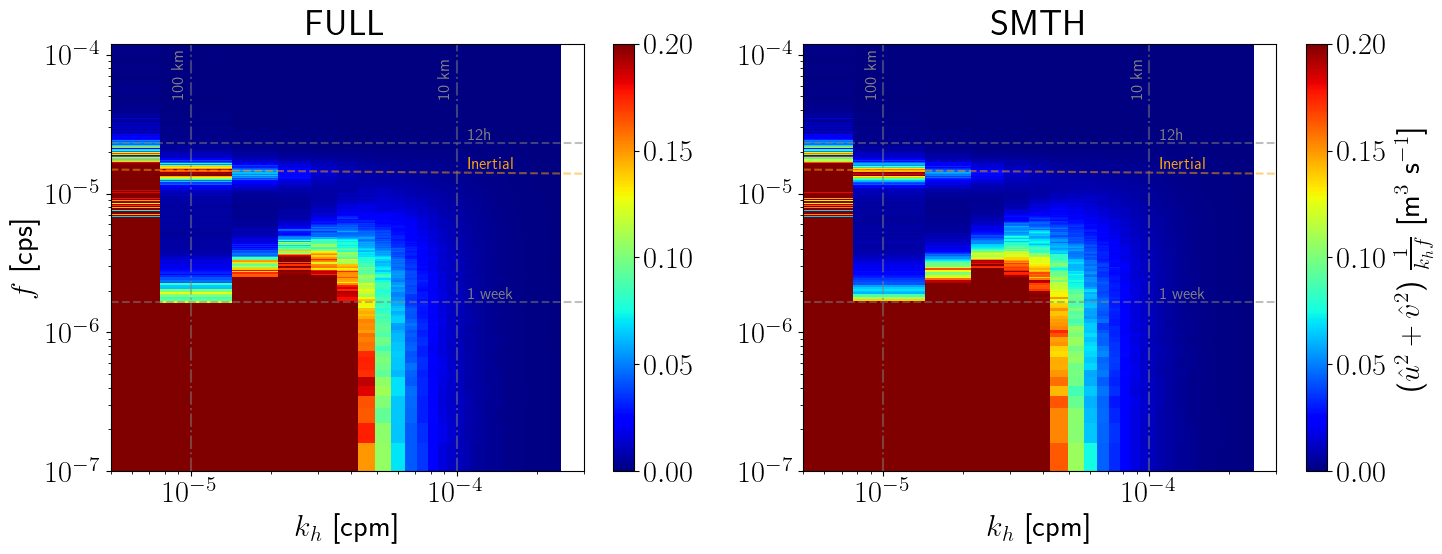

In [16]:
val_min=0
val_max=0.2
xmin=0.5e-5;xmax=3e-4;ymax=1.2e-4;ymin=1e-7

# xmin=1e-6;xmax=3e-4;ymax=1.2e-4;ymin=1e-7

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.pcolormesh(EKE_spec_full.freq_r/dxx,EKE_spec_full.freq_time_counter,
               ((EKE_spec_full.real)/dxx),vmin=val_min,vmax=val_max,cmap='jet')

'Lines for f'
plt.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='orange',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='orange',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='gray',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='gray',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='gray',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='gray',fontsize=12,rotation=90)


# plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
#          color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
# plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='gray',fontsize=12,rotation=90)




plt.title('FULL')
plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.ylabel(r'$f$ [cps] ')
plt.xlabel(r'$k_h$ [cpm]')


plt.subplot(1,2,2)

plt.pcolormesh(EKE_spec_smth.freq_r/dxx,EKE_spec_smth.freq_time_counter,
               ((EKE_spec_smth.real)/dxx),vmin=val_min,vmax=val_max,cmap='jet')

'Lines for f'
plt.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='orange',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='orange',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='gray',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='gray',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='gray',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='gray',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='gray',fontsize=12,rotation=90)


# plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
#          color='gray',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
# plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='gray',fontsize=12,rotation=90)


plt.title('SMTH')


plt.colorbar(label=r'($\hat{u}^2 + \hat{v}^2$)  $\frac{1}{k_h f}$ [m$^{3}$ s$^{-1}$]')

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)


plt.xlabel(r'$k_h$ [cpm]')


plt.tight_layout()

In [17]:
# band_EKE_full=(EKE_spec_full).sel(freq_time_counter=slice(1.39e-5,1.74e-5)).mean('freq_time_counter')
# band_EKE_smth=(EKE_spec_smth).sel(freq_time_counter=slice(1.39e-5,1.74e-5)).mean('freq_time_counter')


band_EKE_full=(EKE_spec_full).sel(freq_time_counter=slice(nif_min,nif_max)).mean('freq_time_counter')
band_EKE_smth=(EKE_spec_smth).sel(freq_time_counter=slice(nif_min,nif_max)).mean('freq_time_counter')

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(band_EKE_full.freq_r/dxx,band_EKE_full/dxx,label='FULL',color='cornflowerblue')
plt.plot(band_EKE_smth.freq_r/dxx,band_EKE_smth/dxx,label='SMTH',color='tomato')


plt.legend()
xmin=8e-6;xmax=3e-4
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlim(xmin,xmax)
plt.ylim(5e-4,0.4)

plt.title(r'($\hat{u}^2 + \hat{v}^2$)  $\frac{1}{k_h f}$ ')
# plt.title('Wind work co-spectrum (16-20h band)')

plt.ylabel(r' PSD [m$^{3}$ s$^{-1}$] ')
plt.xlabel(r'Wavenumber [cpm]')



## Vorticity Spectrum

In [ ]:
zeta_full=v_full_time.differentiate('x')/dxx - u_full_time.differentiate('y')/dxx
zeta_smth=v_smth_time.differentiate('x')/dxx - u_smth_time.differentiate('y')/dxx


zeta_full_spec=xrft.power_spectrum(zeta_full.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)


zeta_smth_spec=xrft.power_spectrum(zeta_smth.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

zeta_iso_full=xrft.isotropize(zeta_full_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
zeta_iso_smth=xrft.isotropize(zeta_smth_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)



In [ ]:
val_min=0
val_max=0.5e-8
xmin=1e-6;xmax=3e-4;ymax=2e-4;ymin=1e-7

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.pcolormesh(zeta_iso_full.freq_r/dxx,zeta_iso_full.freq_time_counter,
               ((zeta_iso_full.real)/dxx),vmin=val_min,vmax=val_max,cmap='rainbow')
'Lines for f'
plt.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='k',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='k',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='white',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='white',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='white',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='white',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='white',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='white',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='white',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='white',fontsize=12,rotation=90)


plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
         color='white',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='white',fontsize=12,rotation=90)



plt.title('FULL')
plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.ylabel(r'Frequency [cps] ')
plt.xlabel(r'Wavenumber [cpm]')

plt.subplot(1,2,2)

plt.pcolormesh(zeta_iso_smth.freq_r/dxx,zeta_iso_smth.freq_time_counter,
               ((zeta_iso_smth.real)/dxx),vmin=val_min,vmax=val_max,cmap='rainbow')

'Lines for f'
plt.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='k',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='k',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='white',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='white',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='white',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='white',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='white',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='white',fontsize=12,rotation=90)

plt.plot([(1e-5),(1e-5)],[ymin,xmax],
         color='white',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-6,0.5e-4,r'100 km',color='white',fontsize=12,rotation=90)


plt.plot([(1/(200*1e3)),(1/(200*1e3))],[ymin,xmax],
         color='white',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(1/(200*1e3) -0.75e-6,0.5e-4,r'200 km',color='white',fontsize=12,rotation=90)


plt.title('SMTH')


plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.xlabel(r'Wavenumber [cpm]')
plt.tight_layout()

In [ ]:
band_zeta_full=(zeta_iso_full).sel(freq_time_counter=slice(1e-5,2e-5))
band_zeta_smth=(zeta_iso_smth).sel(freq_time_counter=slice(1e-5,2e-5))

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(band_zeta_full.freq_r/dxx,band_zeta_full.mean('freq_time_counter')/dxx,label='FULL')
plt.plot(band_zeta_smth.freq_r/dxx,band_zeta_smth.mean('freq_time_counter')/dxx,label='SMTH')

plt.legend()
xmin=1e-6;xmax=3e-4
plt.xscale('log')
plt.yscale('log')
# plt.xlim(1e-5,xmax)
plt.ylim(0,2e-9)

plt.title('Vorticity (Inertial band)')
plt.ylabel(r'PSD ')
plt.xlabel(r'Wavenumber [cpm]')


## Divergence Spectrum

In [18]:
sigma_full=u_full_time.differentiate('x')/dxx + v_full_time.differentiate('y')/dxx
sigma_smth=u_smth_time.differentiate('x')/dxx + v_smth_time.differentiate('y')/dxx

f_bar=sw.f(vart.nav_lat.mean())

In [19]:
sigma_full_spec=xrft.power_spectrum(sigma_full.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)


sigma_smth_spec=xrft.power_spectrum(sigma_smth.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

sigma_iso_full=xrft.isotropize(sigma_full_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
sigma_iso_smth=xrft.isotropize(sigma_smth_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)




In [ ]:
val_min=0
val_max=1e-9
xmin=1e-5;xmax=3e-4;ymax=1.5e-4;ymin=1e-7
# xmin=0.5e-5;xmax=3e-4;ymax=1.2e-4;ymin=1e-7

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.pcolormesh(sigma_iso_full.freq_r/dxx,sigma_iso_full.freq_time_counter,
               ((sigma_iso_full.real)/dxx),vmin=val_min,vmax=val_max,cmap='rainbow')
'Lines for f'
plt.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='k',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='k',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='k',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='k',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='k',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='k',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='k',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='k',fontsize=12,rotation=90)

# plt.plot([(1e-5),(1e-5)],[ymin,xmax],
#          color='k',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
# plt.text(8.5e-6,0.5e-4,r'100 km',color='k',fontsize=12,rotation=90)



plt.title('FULL')
plt.colorbar(label=r'($\widehat{\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}})^2  \frac{1}{k_h f}$ [m s$^{-1}$]')

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.ylabel(r'Frequency [cps] ')
plt.xlabel(r'Wavenumber [cpm]')

plt.subplot(1,2,2)

plt.pcolormesh(sigma_iso_smth.freq_r/dxx,sigma_iso_smth.freq_time_counter,
               ((sigma_iso_smth.real)/dxx),vmin=val_min,vmax=val_max,cmap='rainbow')

'Lines for f'
plt.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='k',linestyle='--',alpha=0.5)
plt.text(1.1e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='k',fontsize=12)
plt.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='k',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='k',fontsize=12)
plt.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='k',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.5)
plt.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='k',fontsize=12)


'Lines for kh'

plt.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='k',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
plt.text(8.5e-5,0.5e-4,r'10 km',color='k',fontsize=12,rotation=90)

# plt.plot([(1e-5),(1e-5)],[ymin,xmax],
#          color='k',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
# plt.text(8.5e-6,0.5e-4,r'100 km',color='k',fontsize=12,rotation=90)


plt.title('SMTH')



plt.title('SMTH')


plt.colorbar(label=r'($\widehat{\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}})^2  \frac{1}{k_h f}$ [m s$^{-1}$]')

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)


plt.xlabel(r'$k_h$ [cpm]')

plt.tight_layout()

In [20]:
# band_sigma_full=(sigma_iso_full).sel(freq_time_counter=slice(1.39e-5,1.74e-5)).mean('freq_time_counter')
# band_sigma_smth=(sigma_iso_smth).sel(freq_time_counter=slice(1.39e-5,1.74e-5)).mean('freq_time_counter')

band_sigma_full=(sigma_iso_full).sel(freq_time_counter=slice(nif_min,nif_max)).mean('freq_time_counter')
band_sigma_smth=(sigma_iso_smth).sel(freq_time_counter=slice(nif_min,nif_max)).mean('freq_time_counter')



Text(0.5, 0, '$k_h$ [cpm]')

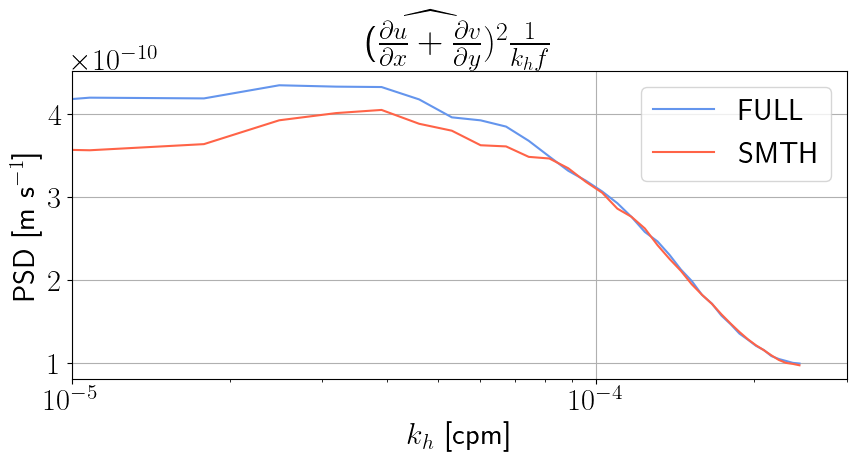

In [21]:
plt.figure(figsize=(10,4))
plt.plot(band_sigma_full.freq_r/dxx,band_sigma_full/dxx,label='FULL',color='cornflowerblue')
plt.plot(band_sigma_smth.freq_r/dxx,band_sigma_smth/dxx,label='SMTH',color='tomato')

plt.legend()
xmin=1e-6;xmax=3e-4
plt.xscale('log')
# plt.yscale('log')
plt.grid()
plt.xlim(1e-5,xmax)
# plt.ylim(5e-4,1)

plt.title(r'($\widehat{\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}})^2  \frac{1}{k_h f}$  ')
# plt.title('Wind work co-spectrum (16-20h band)')

plt.ylabel(r' PSD [m s$^{-1}$] ')
plt.xlabel(r'$k_h$ [cpm]')




# Ratio and  Ogive plots

In [29]:
cb2.ax.get_yticklines?

Object `cb2.ax.get_yticklines` not found.


In [30]:
(1/nif_min)/60/60

23.14814814814815

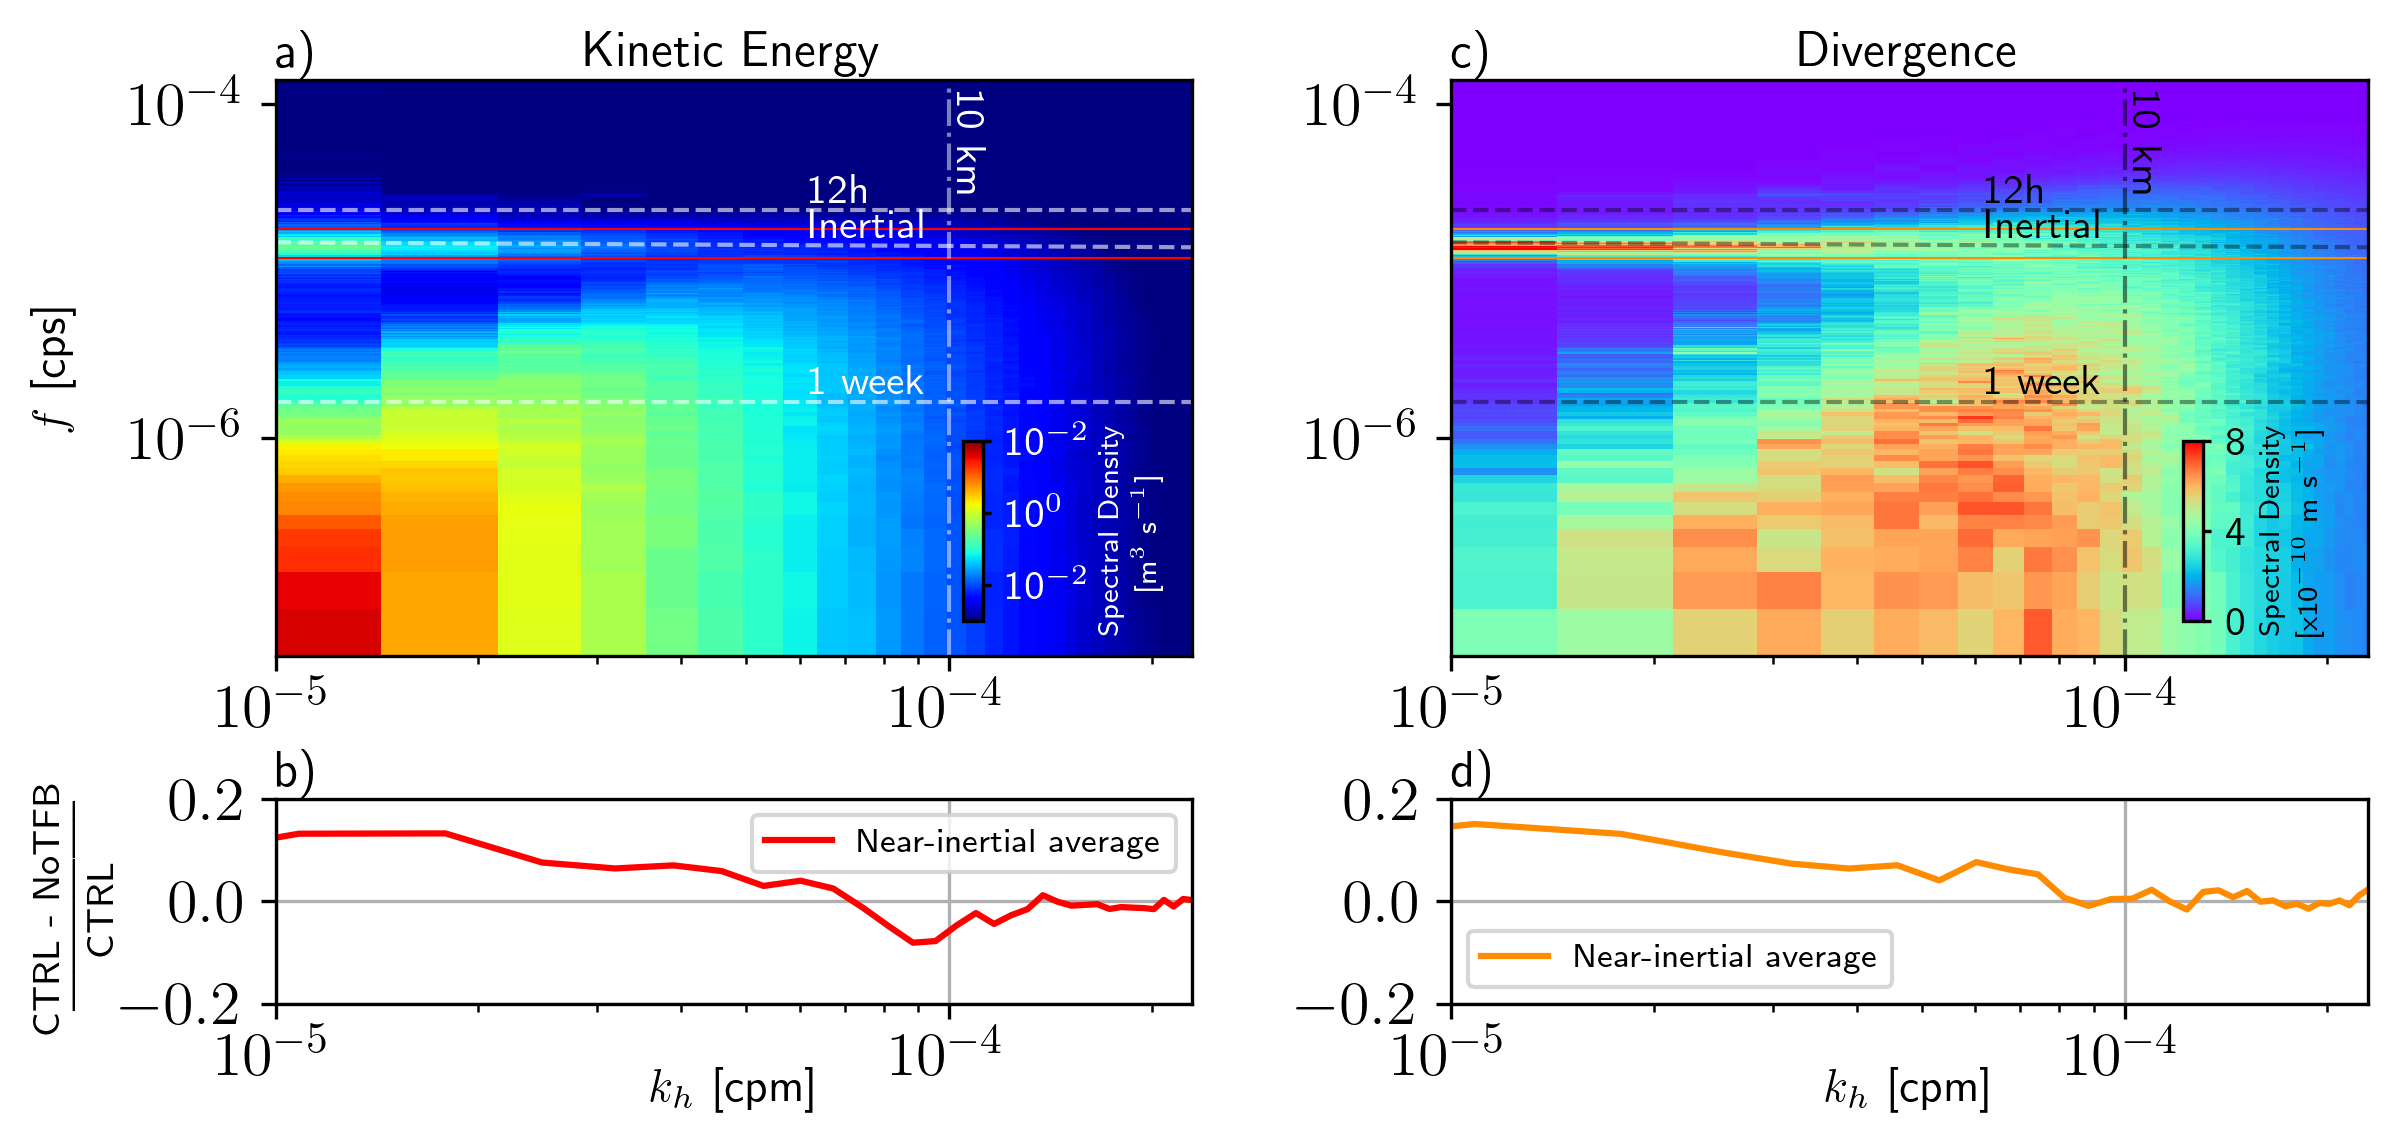

In [57]:
plt.rcParams.update({'font.size': 15})


# val_min_EKE=0
# val_max_EKE=0.3

val_min_EKE=-3
val_max_EKE=2


val_min_div=0
val_max_div=0.8e-9

# val_min_div=-11
# val_max_div=-8.5


# xmin=1e-5;xmax=2e-4;ymax=1.2e-4;ymin=1e-7

xmin=1e-5;xmax=2.3e-4;ymax=1.4e-4;ymin=0.5e-7


fig = plt.figure(figsize=(9,4),dpi=300)
# fig = plt.figure(figsize=(7,9))
gs1 = gridspec.GridSpec(40,50)


ax0 = fig.add_subplot(gs1[0:25,:22])

# cc0=ax0.pcolormesh(EKE_spec_full.freq_r/dxx,EKE_spec_full.freq_time_counter,
#                ((EKE_spec_full.real)/dxx),vmin=val_min_EKE,vmax=val_max_EKE,cmap='jet')

cc0=ax0.pcolormesh(EKE_spec_full.freq_r/dxx,EKE_spec_full.freq_time_counter,
               np.log10((EKE_spec_full.real)/dxx),vmin=val_min_EKE,vmax=val_max_EKE,cmap='jet')
# 'Lines for f'
# ax0.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
#          color='w',linestyle='--',alpha=0.4)
# ax0.text(1.1e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+1e-6,
#          r'Inertial',color='w',fontsize=12)


ax0.plot([xmin,xmax],[nif_min,nif_min],[nif_max,nif_max],
         color='red',linestyle='-',alpha=1,linewidth=0.5)
'Lines for f'
ax0.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='w',linestyle='--',alpha=0.6,linewidth=1)
ax0.text(0.62e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+2e-6,
         r'Inertial',color='w',fontsize=10)
ax0.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='w',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.6,linewidth=1)
ax0.text(0.62e-4,1/(12*60*60)+2.5e-6,
         r'12h',color='w',fontsize=10)
ax0.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='w',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.6,linewidth=1)
ax0.text(0.62e-4,1/(24*7*60*60)+2e-7,
         r'1 week',color='w',fontsize=10)


ax0.plot([xmin,xmax],[nif_min,nif_min],[nif_max,nif_max],
         color='r',linestyle='-',alpha=1,linewidth=0.5)
# ax2.fill_between(y1=nif_min,y2=nif_max,x=color='cyan',alpha=0.5)

'Lines for kh'

ax0.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='w',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.',linewidth=1)
ax0.text(1e-4,0.3e-4,r'10 km',color='w',fontsize=10,rotation=-90)




# plt.plot([(1e-5),(1e-5)],[ymin,xmax],
#          color='k',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
# plt.text(8.5e-6,0.5e-4,r'100 km',color='k',fontsize=12,rotation=90)
# ax0.set_title('FULL - SMTH',fontsize=20)

# ax0.set_title(r'$\frac{\mathrm{FULL} - \mathrm{SMTH}}{\mathrm{FULL}}$',fontsize=20,pad=10)
ax0.set_title(r'Kinetic Energy  ',fontsize=12)
ax0.set_title(r' a)',fontsize=12,pad=1,loc='left')


cbaxes = inset_axes(ax0, width="2%", height="15%", loc=2,borderpad=2,bbox_to_anchor=(900,-380, 1000, 1200))
cb0 = plt.colorbar(cc0,cax=cbaxes,fraction=0.04,aspect=35,shrink=0.850,orientation='vertical',
                   ticks=[-2,0,2])
cb0.set_label(label=r'Spectral Density' + '\n' + r'[m$^3$ s$^{-1}$]',fontsize=7,labelpad=2,color='w')
cb0.ax.tick_params(labelsize=10,size=2,color='k')
cb0.ax.set_yticklabels([r'10$^{\mathrm{-2}}$',r'10$^{\mathrm{0}}$',r'10$^{\mathrm{-2}}$'],fontsize=10,color='w')
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim(xmin,xmax)
ax0.set_ylim(ymin,ymax)




# cbbox = inset_axes(ax0, '15%', '90%', loc = 1)
# [cbbox.spines[k].set_visible(False) for k in cbbox.spines]
# cbbox.tick_params(axis='both', left='off', top='off', right='off', 
#                   bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
# cbbox.set_facecolor([1,1,1,0.7])
# cbaxes = inset_axes(cbbox, '30%', '95%', loc = 1)


ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim(xmin,xmax)
ax0.set_ylim(ymin,ymax)
# ax0.tick_params(size=10)
ax0.set_ylabel(r'$f$ [cps]',fontsize=11,labelpad=13)
# ax0.set_xlabel(r'Wavenumber [cpm]')

                 
                 
ax2 = fig.add_subplot(gs1[0:25,28:])

cc2=ax2.pcolormesh(sigma_iso_full.freq_r/dxx,sigma_iso_full.freq_time_counter,
               ((sigma_iso_full.real)/dxx),vmin=val_min_div,vmax=val_max_div,cmap='rainbow')
# cc2=ax2.pcolormesh(sigma_iso_full.freq_r/dxx,sigma_iso_full.freq_time_counter,
#                np.log10((sigma_iso_full.real)/dxx),vmin=val_min_div,vmax=val_max_div,cmap='rainbow')


'Lines for f'
ax2.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='k',linestyle='--',alpha=0.4,linewidth=1)
ax2.text(0.62e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+2e-6,
         r'Inertial',color='k',fontsize=10)
ax2.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='k',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.4,linewidth=1)
ax2.text(0.62e-4,1/(12*60*60)+2.5e-6,
         r'12h',color='k',fontsize=10)
ax2.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='k',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.4,linewidth=1)
ax2.text(0.62e-4,1/(24*7*60*60)+2e-7,
         r'1 week',color='k',fontsize=10)


ax2.plot([xmin,xmax],[nif_min,nif_min],[nif_max,nif_max],
         color='darkorange',linestyle='-',alpha=1,linewidth=0.5)
# ax2.fill_between(y1=nif_min,y2=nif_max,x=color='cyan',alpha=0.5)

'Lines for kh'

ax2.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='k',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.',linewidth=1)
ax2.text(1e-4,0.3e-4,r'10 km',color='k',fontsize=10,rotation=-90)

# ax2.set_title(r'$\frac{\mathrm{FULL} - \mathrm{SMTH}}{\mathrm{FULL}}$',fontsize=20,pad=10)
ax2.set_title(r'Divergence',fontsize=12)
ax2.set_title(r' c)',fontsize=12,pad=3,loc='left')

# # cb2 = plt.colorbar(cc2,cax=ax2,fraction=0.04,aspect=35,shrink=0.850,orientation='vertical')
# cb2 = plt.colorbar(cc2,orientation='vertical')


cbaxes = inset_axes(ax2, width="2%", height="15%", loc=2,borderpad=2,bbox_to_anchor=(2120,-380, 1000, 1200)) 
cb2 = plt.colorbar(cc2,cax=cbaxes,fraction=0.04,aspect=35,shrink=0.850,orientation='vertical',
                   ticks=[0,4e-10,8e-10])
cb2.set_label(label=r'Spectral Density' + '\n' + r'[x10$^{-10}$ m s$^{-1}$]',fontsize=7,fontweight='bold',labelpad=3)
cb2.ax.tick_params(labelsize=10,size=2)
cb2.ax.set_yticklabels([0,4,8],fontsize=10)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
# ax2.set_ylabel(r'$f$ [cps]',)

                 

ax1 =fig.add_subplot(gs1[31:,:22])


ax1.plot(band_EKE_full.freq_r/dxx,(band_EKE_full-band_EKE_smth)/(band_EKE_full),
         label='Near-inertial average',color='red')
ax1.set_xscale('log')
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(-0.2,0.2)

ax1.legend(fontsize=8)
ax1.grid()
# ax1.set_yticks([-0.2,0,0.2],[r'$-20$',r'$0$',r'$20$'],fontsize=15)
ax1.set_yticks([-0.2,0,0.2],fontsize=15)

# ax1.set_title('Near-inertial average',fontsize=12)
ax1.set_title(r' b)',fontsize=12,pad=3,loc='left')

# ax1.set_ylabel(r'$\mathrm{(\frac{\mathrm{FULL - SMTH}}{\mathrm{FULL}})}$',labelpad=1,fontsize=12)
# ax1.set_ylabel(r'${\frac{\mathbf{TFB} - \mathbf{NoTFB}}{\mathbf{TFB}}}$',
#                labelpad=1,fontsize=14,fontweight='bold')
# ax1.set_ylabel(r'${\frac{\mathrm{CTRL} - \mathrm{NoTFB}}{\mathrm{CTRL}}}$',
#                labelpad=1,fontsize=14,fontweight='bold')
ax1.text(0.035,0.09,'CTRL - NoTFB',
         fontsize=9,rotation=90,transform=plt.gcf().transFigure)

ax1.text(0.041,0.11,'-----------------',
         fontsize=9,rotation=90,transform=plt.gcf().transFigure)

ax1.text(0.055,0.155,'CTRL',
         fontsize=9,rotation=90,transform=plt.gcf().transFigure)

# ax1.text(0.045,0.07,r'${\frac{\mathbf{CTRL} - \mathbf{NoTFB}}{\mathbf{CTRL}}}$',
#          fontsize=13,rotation=90,transform=plt.gcf().transFigure)



ax1.set_xlabel(r'$k_h$ [cpm]',fontsize=11,labelpad=-5)




ax3 =  fig.add_subplot(gs1[31:,28:])


ax3.plot(band_sigma_full.freq_r/dxx,(band_sigma_full-band_sigma_smth)/(band_sigma_full),
         label='Near-inertial average',color='darkorange')


ax3.set_xscale('log')
# plt.yscale('log')
# plt.grid()
ax3.set_xlim(xmin,xmax)
ax3.set_ylim(-0.2,0.2)

ax3.legend(fontsize=8)
ax3.grid()
# ax3.set_yticks([-0.2,0,0.2],[r'$-20$',r'$0$',r'$20$'],fontsize=15)
ax3.set_yticks([-0.2,0,0.2],fontsize=15)


# ax3.set_title('Ratio',fontsize=12)
# ax3.set_title(r'$\mathrm{(\frac{\mathrm{FULL - SMTH}}{\mathrm{FULL}})}$',fontsize=12,pad=-100)

ax3.set_title(r' d)',fontsize=12,pad=1,loc='left')

# ax3.set_ylabel(r'$\frac{\mathrm{FULL} - \mathrm{SMTH}}{\mathrm{FULL}}$',fontsize=15)

ax3.set_xlabel(r'$k_h$ [cpm]',fontsize=11,labelpad=-5)

plt.tight_layout()
fig.savefig('/homes/metogra/iufarias/FeedbackSubmeso/notebooks/TFB_NIW_proposal/figures/DIV_EKE_omega_kh_NIW_squeezed.png',bbox_inches='tight',bbox_transform=ax0.figure.transFigure)

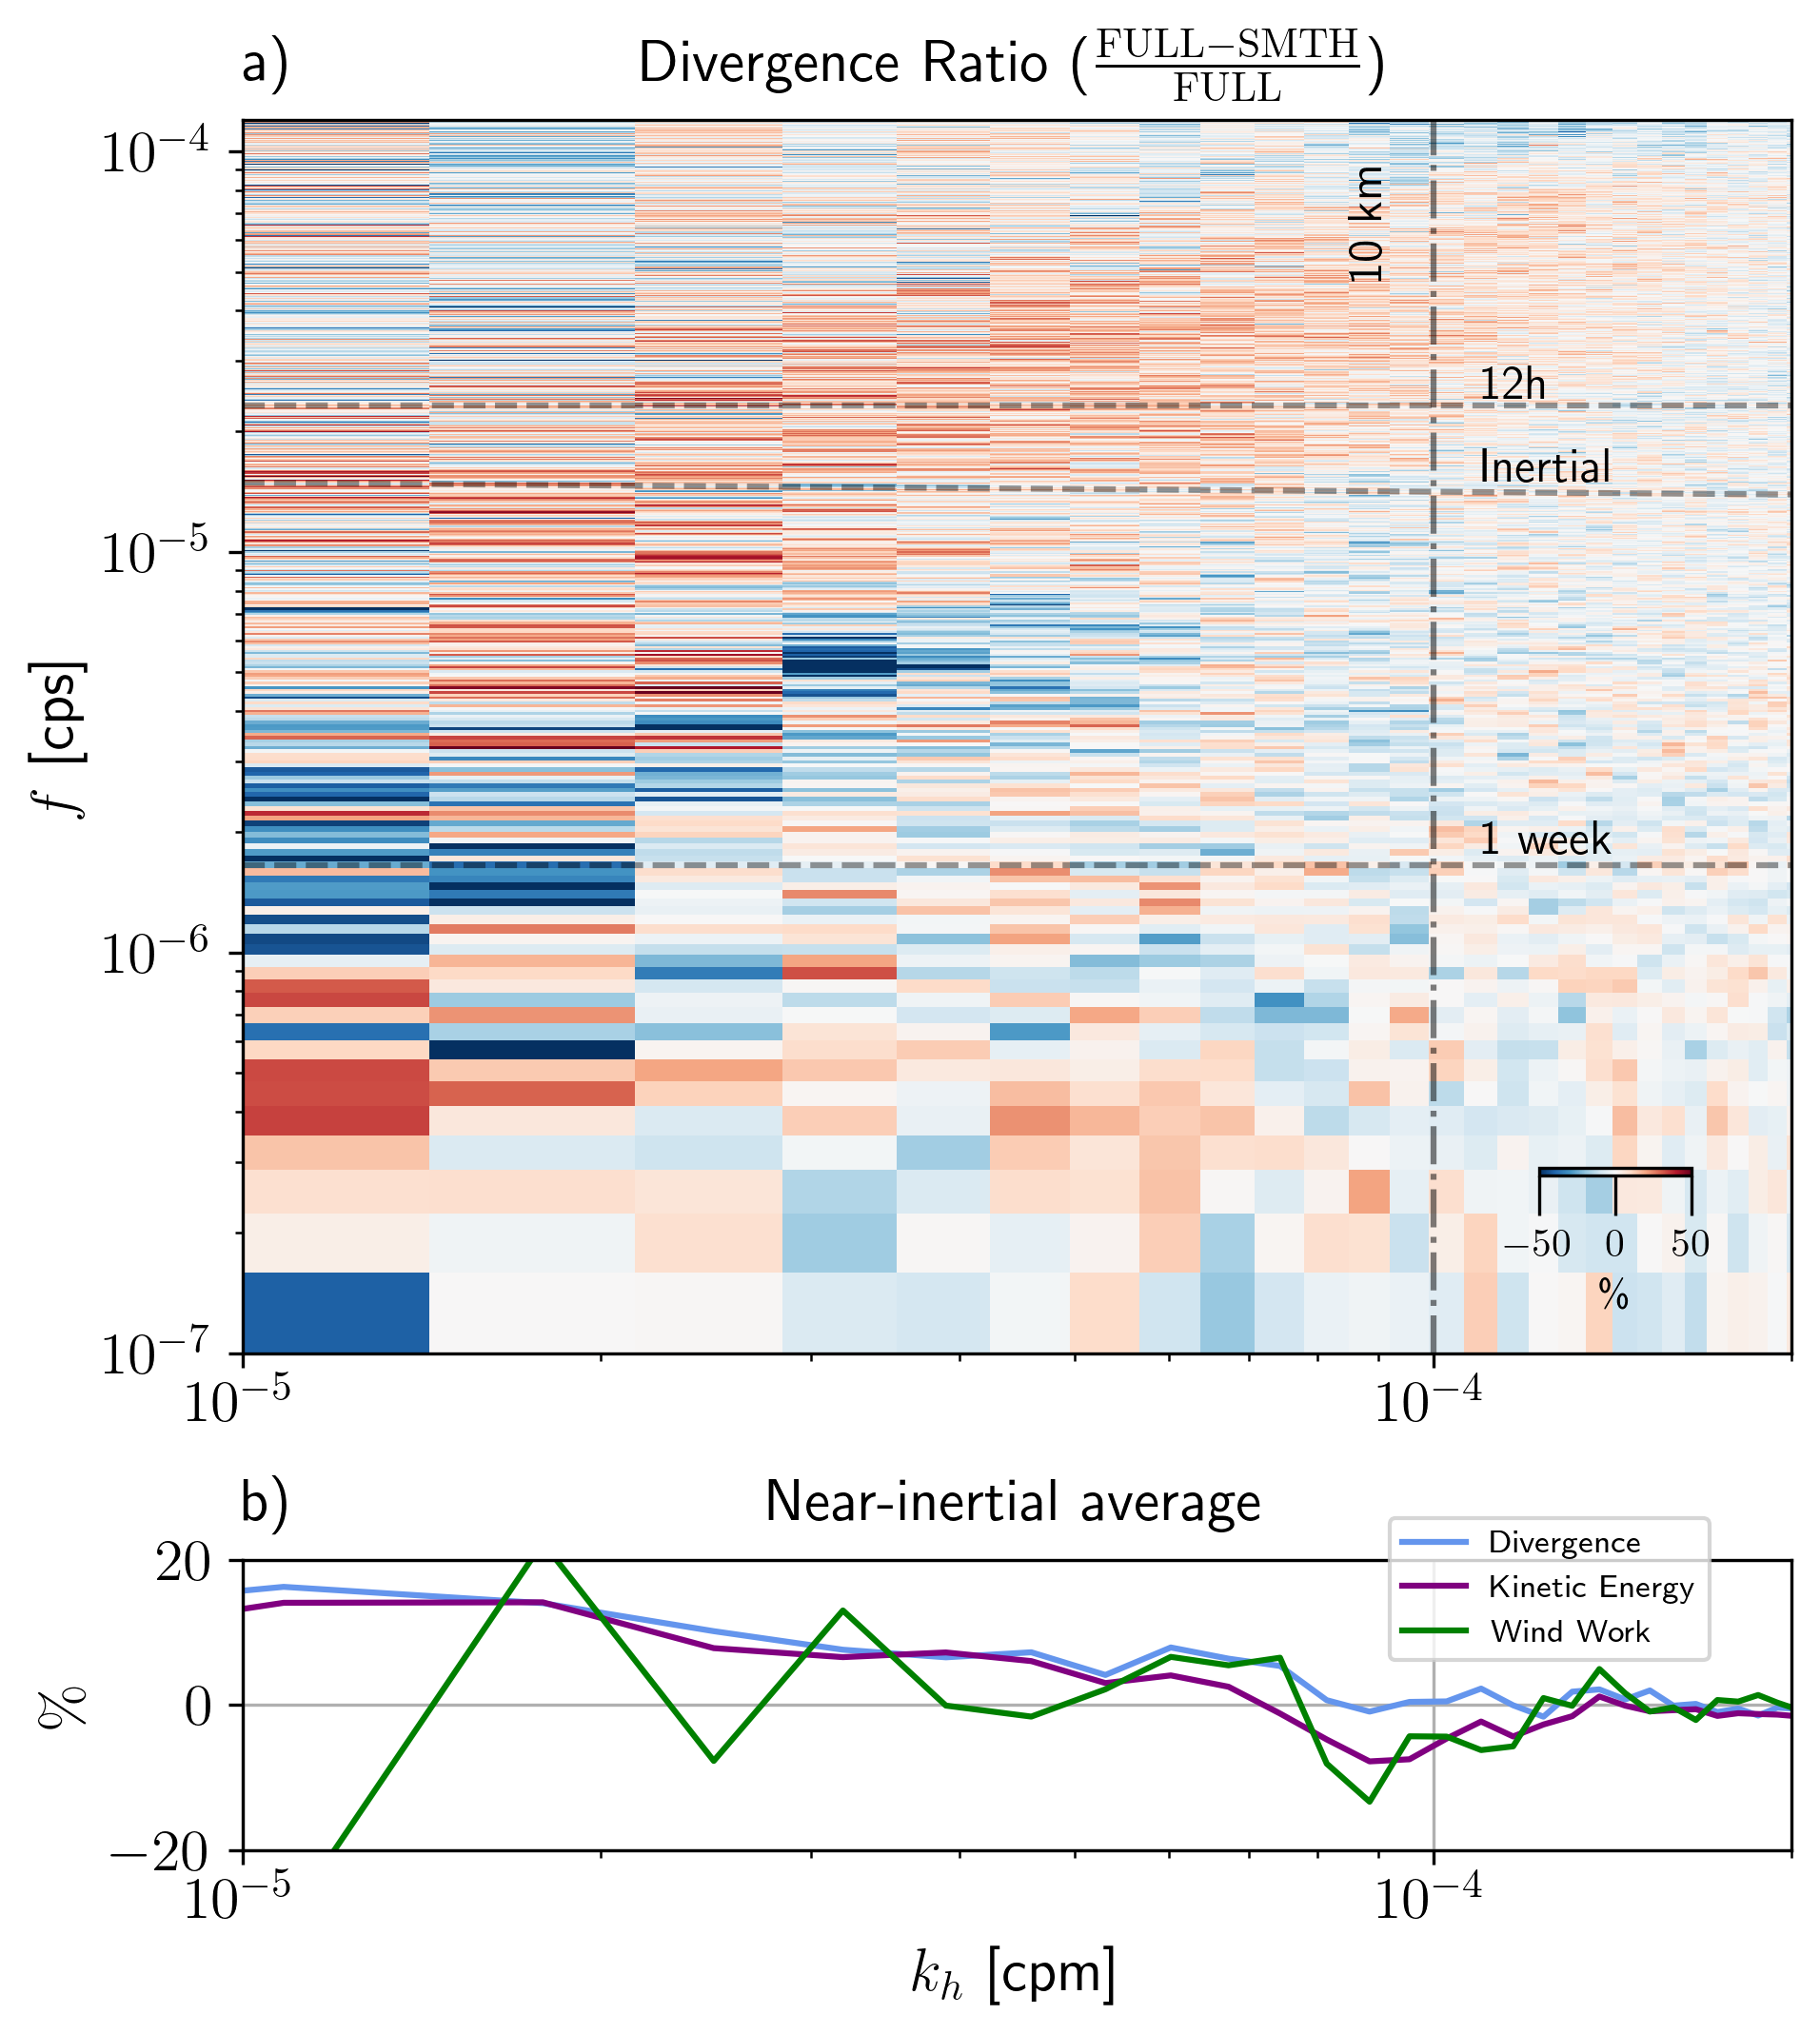

In [33]:
plt.rcParams.update({'font.size': 15})

val_min=-50
val_max=50
xmin=1e-5;xmax=2e-4;ymax=1.2e-4;ymin=1e-7
# xmin=0.5e-5;xmax=3e-4;ymax=1.2e-4;ymin=1e-7


fig = plt.figure(figsize=(7,9),dpi=300)
gs1 = gridspec.GridSpec(40,20)


ax0 = fig.add_subplot(gs1[0:25,:20])

# cc0=ax0.pcolormesh(sigma_iso_full.freq_r/dxx,sigma_iso_full.freq_time_counter,
#                ((sigma_iso_full.real-sigma_iso_smth.real)/dxx)/1e-10,vmin=val_min,vmax=val_max,cmap='seismic')


cc0=ax0.pcolormesh(sigma_iso_full.freq_r/dxx,sigma_iso_full.freq_time_counter,
               100*((sigma_iso_full.real-sigma_iso_smth.real)/(sigma_iso_full.real)),vmin=val_min,vmax=val_max,cmap='RdBu_r')
'Lines for f'
ax0.plot([xmin,xmax],[sw.f(vart.nav_lat.mean()/(2*np.pi)),sw.f(vart.nav_lat.mean())/(2*np.pi)],
         color='k',linestyle='--',alpha=0.4)
ax0.text(1.1e-4,sw.f(vart.nav_lat.mean())/(2*np.pi)+1e-6,
         r'Inertial',color='k',fontsize=12)
ax0.plot([xmin,xmax],[1/(12*60*60),1/(12*60*60)],
         color='k',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.4)
ax0.text(1.1e-4,1/(12*60*60)+1e-6,
         r'12h',color='k',fontsize=12)
ax0.plot([xmin,xmax],[1/(24*7*60*60),1/(24*7*60*60)],
         color='k',label=r'$\frac{f_o}{2\pi}$',linestyle='--',alpha=0.4)
ax0.text(1.1e-4,1/(24*7*60*60)+1e-7,
         r'1 week',color='k',fontsize=12)


'Lines for kh'

ax0.plot([(1e-4),(1e-4)],[ymin,xmax],
         color='k',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
ax0.text(8.5e-5,0.5e-4,r'10 km',color='k',fontsize=12,rotation=90)

# plt.plot([(1e-5),(1e-5)],[ymin,xmax],
#          color='k',label=r'$\frac{f_o}{2\pi}$',alpha=0.5,linestyle='-.')
# plt.text(8.5e-6,0.5e-4,r'100 km',color='k',fontsize=12,rotation=90)
# ax0.set_title('FULL - SMTH',fontsize=20)

# ax0.set_title(r'$\frac{\mathrm{FULL} - \mathrm{SMTH}}{\mathrm{FULL}}$',fontsize=20,pad=10)
ax0.set_title(r'Divergence Ratio ($\frac{\mathrm{FULL} - \mathrm{SMTH}}{\mathrm{FULL}}$) ',fontsize=15,pad=10)
ax0.set_title(r' a)',fontsize=15,pad=10,loc='left')




cbaxes = inset_axes(ax0, width="20%", height="2%", loc=2,borderpad=2,bbox_to_anchor=(1500,1000, 800, 400)) 
cb0 = plt.colorbar(cc0,cax=cbaxes,fraction=0.04,aspect=35,shrink=0.850,orientation='horizontal')
# cb0.set_label(label=r'($\widehat{\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}})^2  \frac{1}{k_h f}$' + '\n' + r'[10$^{-10}$ m s$^{-1}$]',fontsize=10)
cb0.set_label(label=r'\%',fontsize=10)

cb0.ax.tick_params(labelsize=10,size=10)





ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim(xmin,xmax)
ax0.set_ylim(ymin,ymax)
# ax0.tick_params(size=10)
ax0.set_ylabel(r'$f$ [cps]',)
# ax0.set_xlabel(r'Wavenumber [cpm]')


ax1 = fig.add_subplot(gs1[29:35,:20])


ax1.plot(band_sigma_full.freq_r/dxx,(band_sigma_full-band_sigma_smth)/(0.5*band_sigma_full+ 0.5*band_sigma_smth),label='Divergence',color='cornflowerblue')
ax1.plot(band_EKE_full.freq_r/dxx,(band_EKE_full-band_EKE_smth)/(0.5*band_EKE_full+ 0.5*band_EKE_smth),label='Kinetic Energy',color='purple')
ax1.plot(band_ww_full.freq_r/dxx,(band_ww_full-band_ww_smth)/(0.5*band_ww_full+ 0.5*band_ww_smth),label='Wind Work',color='green')



ax1.set_xscale('log')
# plt.yscale('log')
# plt.grid()
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(-0.2,0.2)

ax1.legend(fontsize=8,bbox_to_anchor=(0.73, 0.6))
ax1.grid()
ax1.set_yticks([-0.2,0,0.2],[r'$-20$',r'$0$',r'$20$'],fontsize=15)

ax1.set_title('Near-inertial average',fontsize=15)
ax1.set_title(r' b)',fontsize=15,pad=10,loc='left')

# ax1.set_ylabel(r'$\frac{\mathrm{FULL} - \mathrm{SMTH}}{\mathrm{FULL}}$',fontsize=15)
ax1.set_ylabel(r'$\mathrm{\%}$')

ax1.set_xlabel(r'$k_h$ [cpm]')


# plt.tight_layout()
fig.savefig('/homes/metogra/iufarias/FeedbackSubmeso/notebooks/TFB_NIW_proposal/figures/DIV_omega_kh_NIW.png',bbox_inches='tight',bbox_transform=ax0.figure.transFigure)

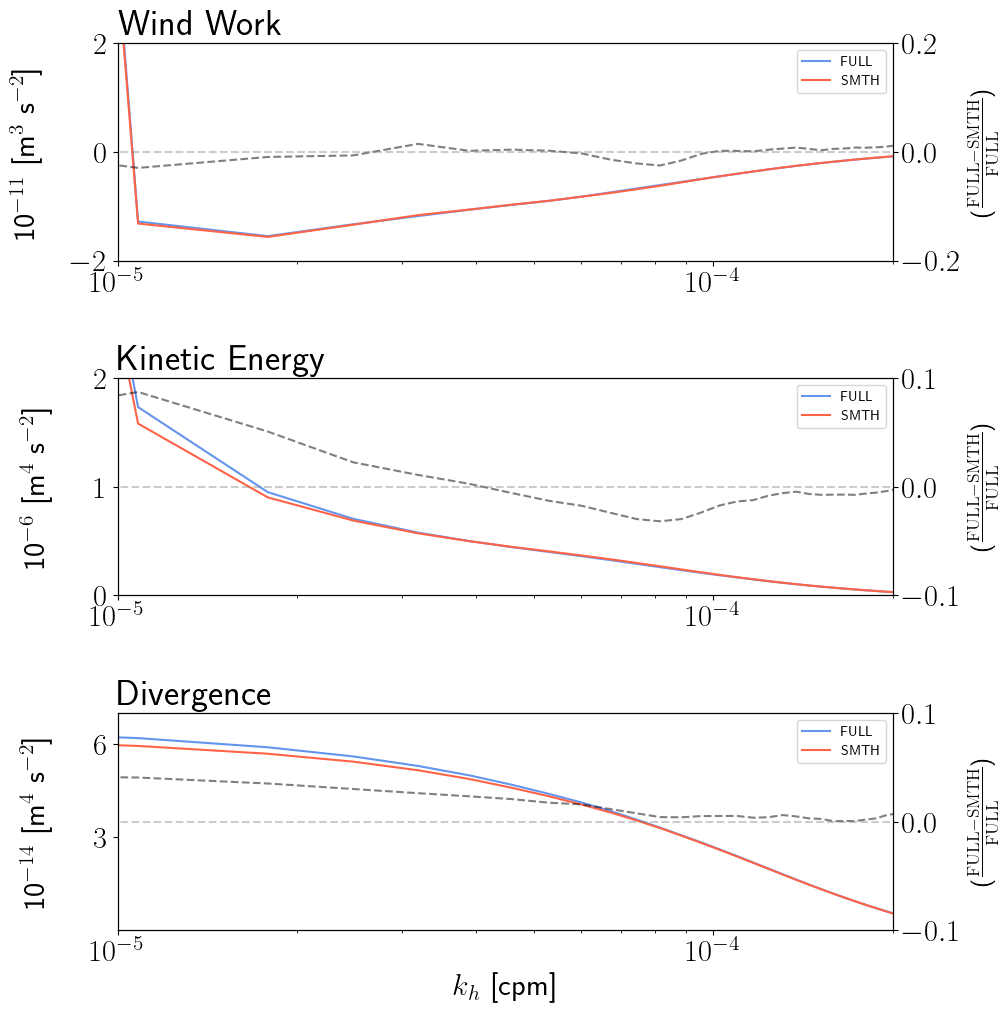

In [33]:
WW_ogive_FULL=ogive(deltaf=np.diff(band_ww_full.freq_r/dxx).mean(),G=(band_ww_full.real/dxx)) #in metersss
WW_ogive_SMTH=ogive(deltaf=np.diff(band_ww_smth.freq_r/dxx).mean(),G=(band_ww_smth.real/dxx))

EKE_ogive_FULL=ogive(deltaf=np.diff(band_EKE_full.freq_r/dxx).mean(),G=(band_EKE_full.real/dxx)) #in metersss
EKE_ogive_SMTH=ogive(deltaf=np.diff(band_EKE_smth.freq_r/dxx).mean(),G=(band_EKE_smth.real/dxx))

DIV_ogive_FULL=ogive(deltaf=np.diff(band_sigma_full.freq_r/dxx).mean(),G=(band_sigma_full.real/dxx))
DIV_ogive_SMTH=ogive(deltaf=np.diff(band_sigma_smth.freq_r/dxx).mean(),G=(band_sigma_smth.real/dxx))

kmin=1e-5

fig = plt.figure(figsize=(10,12))
gs1 = gridspec.GridSpec(25,20)

ax1 = fig.add_subplot(gs1[0:6,:])

KF=1e-11

ax1.plot(band_ww_full.freq_r/dxx,WW_ogive_FULL/KF,label='FULL',color='cornflowerblue')
ax1.plot(band_ww_smth.freq_r/dxx,WW_ogive_SMTH/KF,label='SMTH',color='tomato')

ax1.legend(fontsize=10)
ax1.set_xscale('log')


# ax1.set_title(r'$\int Re(\frac{\hat{\tau} \, \cdot \, \hat{u}}{\rho_0})\, {dk{_h}}$')
ax1.set_title(r' Wind Work',loc='left')
ax1.set_ylabel(r'10$^{-11}$ [m$^{3}$ s$^{-2}$]',labelpad=20)

ax1.set_xlim(kmin,2e-4)

ax1.set_ylim(-2,2)
ax1.set_yticks([-2,0,2])

ax12=ax1.twinx()
ax12.plot(band_ww_full.freq_r/dxx,(WW_ogive_FULL-WW_ogive_SMTH)/(WW_ogive_FULL),alpha=0.5,linestyle='dashed',color='k')
ax12.plot([(band_ww_full.freq_r/dxx).min(),(band_ww_full.freq_r/dxx).max()],[0,0],color='grey',linestyle='--',alpha=0.4)

ax12.set_ylabel(r'($\frac{\mathrm{FULL} - \mathrm{SMTH}}{\mathrm{FULL}}$)',fontsize=18,color='k')
ax12.set_xscale('log')
# ax12.set_yticks([-0.1,0.1])
ax12.set_ylim(-0.2,0.2)
ax12.tick_params(axis='y', colors='k')




ax2 = fig.add_subplot(gs1[9:15,:])

KF2=1e-6
ax2.plot(band_EKE_full.freq_r/dxx,EKE_ogive_FULL/KF2,label='FULL',color='cornflowerblue')
ax2.plot(band_EKE_smth.freq_r/dxx,EKE_ogive_SMTH/KF2,label='SMTH',color='tomato')

ax2.legend(fontsize=10)
ax2.set_xscale('log')

ax2.set_ylim(0,2)
ax2.set_xticks([2,4])
# ax2.set_yticklabels([r'$0$',r'$0.5$',r'$1$'])


ax2.set_xlim(kmin,2e-4)

ax2.set_title(r' Kinetic Energy' ,loc='left')
ax2.set_ylabel(r'10$^{-6}$ [m$^{4}$ s$^{-2}$]',labelpad=30)


ax22=ax2.twinx()
ax22.plot(band_ww_full.freq_r/dxx,(EKE_ogive_FULL-EKE_ogive_SMTH)/(EKE_ogive_FULL),alpha=0.5,linestyle='dashed',color='k')
ax22.plot([(band_EKE_full.freq_r/dxx).min(),(band_EKE_full.freq_r/dxx).max()],[0,0],color='grey',linestyle='--',alpha=0.4)

ax22.set_ylabel(r'($\frac{\mathrm{FULL} - \mathrm{SMTH}}{\mathrm{FULL}}$)',fontsize=18,color='k')
ax22.set_xscale('log')
ax22.set_ylim(-0.1,0,0.1)
ax22.set_yticks([-0.1,0,0.1])

ax22.tick_params(axis='y', colors='k')


ax3 = fig.add_subplot(gs1[18:24,:])
KF3=1e-14
ax3.plot(band_sigma_full.freq_r/dxx,DIV_ogive_FULL/KF3,label='FULL',color='cornflowerblue')
ax3.plot(band_sigma_smth.freq_r/dxx,DIV_ogive_SMTH/KF3,label='SMTH',color='tomato')

ax3.legend(fontsize=10)
ax3.set_xscale('log')

ax3.set_ylim(0,7)
ax3.set_yticks([3,6])
# ax3.set_yticklabels([r'$0$',r'$0.5$',r'$1$'])
ax3.set_xlabel(r'$k_h$ [cpm]')

ax3.set_xlim(kmin,2e-4)

ax3.set_title(r' Divergence',loc='left')

ax3.set_ylabel(r'10$^{-14}$ [m$^{4}$ s$^{-2}$]',labelpad=30)

ax32=ax3.twinx()
ax32.plot(band_sigma_full.freq_r/dxx,((DIV_ogive_FULL-DIV_ogive_SMTH)/(DIV_ogive_FULL)),alpha=0.5,linestyle='dashed',color='k')
ax32.plot([(band_sigma_full.freq_r/dxx).min(),(band_sigma_full.freq_r/dxx).max()],[0,0],color='grey',linestyle='--',alpha=0.4)

ax32.set_ylabel(r'($\frac{\mathrm{FULL} - \mathrm{SMTH}}{\mathrm{FULL}}$)',fontsize=18,color='k')
ax32.set_xscale('log')

ax32.set_ylim(-0.1,0.1)
ax32.set_yticks([-0.1,0,0.1])

ax32.tick_params(axis='y', colors='k')


plt.tight_layout()

# Monthly Analysis

In [55]:
monstr=['Jan','Feb','Mar','Apr','May','Jun']
mont_int=np.unique(u_full_time.time_counter.dt.month)

In [25]:
WW_FULL_table=[]
WW_SMTH_table=[]

for month_x in range(6):

    tx_full_m=taux_full[taux_full.time_counter.dt.month==month_x+1]
    ty_full_m=tauy_full[tauy_full.time_counter.dt.month==month_x+1]
    tx_smth_m=taux_smth[taux_smth.time_counter.dt.month==month_x+1]
    ty_smth_m=tauy_smth[tauy_smth.time_counter.dt.month==month_x+1]
    
    u_full_m=u_full_time[u_full_time.time_counter.dt.month==month_x+1]
    v_full_m=v_full_time[v_full_time.time_counter.dt.month==month_x+1]
    u_smth_m=u_smth_time[u_smth_time.time_counter.dt.month==month_x+1]
    v_smth_m=v_smth_time[v_smth_time.time_counter.dt.month==month_x+1]

    taux_full_m_spec=xrft.cross_spectrum(tx_full_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        u_full_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    tauy_full_m_spec=xrft.cross_spectrum(ty_full_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        v_full_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    taux_smth_m_spec=xrft.cross_spectrum(tx_smth_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        u_smth_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    tauy_smth_m_spec=xrft.cross_spectrum(ty_smth_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        v_smth_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    ww_full_spec_m=(taux_full_m_spec + tauy_full_m_spec)
    ww_smth_spec_m=(taux_smth_m_spec + tauy_smth_m_spec)

    ww_iso_full_m=xrft.isotropize(ww_full_spec_m,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
    ww_iso_smth_m=xrft.isotropize(ww_smth_spec_m,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)

    
    WW_FULL_table.append(ww_iso_full_m)
    WW_SMTH_table.append(ww_iso_smth_m)

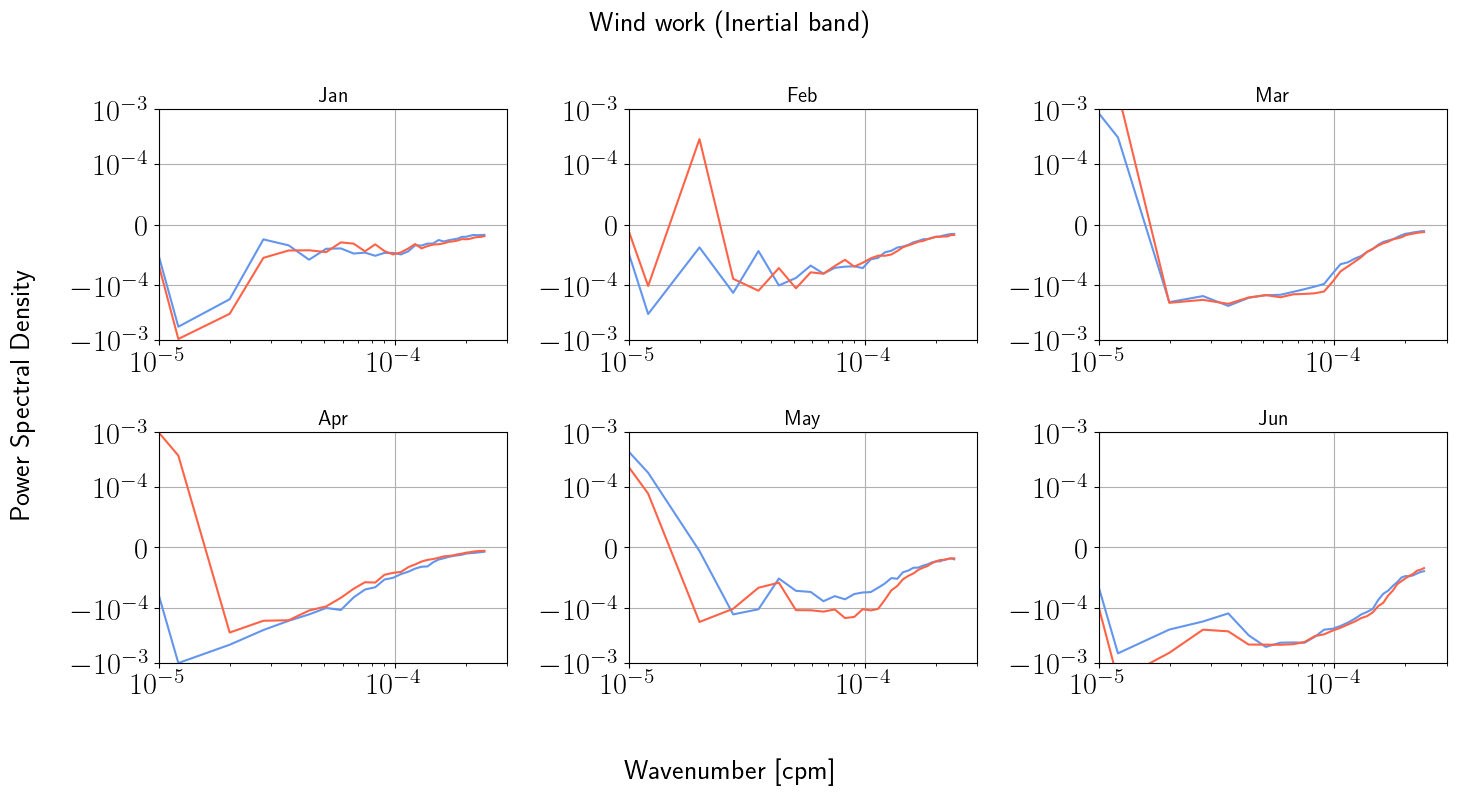

In [218]:
fig, ax = plt.subplots(2,3,figsize=(15,8))

ax=np.ravel(ax)
for i in range(6):

    WW_FULL_band=(WW_FULL_table[i]).real.sel(freq_time_counter=slice(1.4e-5,1.7e-5))
    WW_SMTH_band=(WW_SMTH_table[i]).real.sel(freq_time_counter=slice(1.4e-5,1.7e-5))

    ax[i].plot(WW_FULL_band.freq_r/dxx,WW_FULL_band.mean('freq_time_counter')/dxx,label='FULL',color='cornflowerblue')
    ax[i].plot(WW_SMTH_band.freq_r/dxx,WW_SMTH_band.mean('freq_time_counter')/dxx,label='SMTH',color='tomato')

    # xmin=1e-6;xmax=3e-4
    ax[i].set_xscale('log')
    ax[i].set_yscale('symlog',linthresh=1e-4)
    ax[i].set_xlim(1e-5,xmax)
    ax[i].set_ylim(-1e-3,1e-3)
    ax[i].set_title('{0}'.format(monstr[i]),fontsize=15)
    ax[i].grid()
    # ax[1].set_ylim(1e-10,0.6e-9)



fig.suptitle('Wind work (Inertial band)',fontsize=20)
fig.supylabel(r'Power Spectral Density ',fontsize=20)
fig.supxlabel(r'Wavenumber [cpm]',fontsize=20)

plt.tight_layout()

In [66]:
EKE_FULL_table=[]
EKE_SMTH_table=[]

for month_x in range(6):

    u_full_m=u_full_time[u_full_time.time_counter.dt.month==month_x+1]
    v_full_m=v_full_time[v_full_time.time_counter.dt.month==month_x+1]
    u_smth_m=u_smth_time[u_smth_time.time_counter.dt.month==month_x+1]
    v_smth_m=v_smth_time[v_smth_time.time_counter.dt.month==month_x+1]

    u_full_m_spec=xrft.power_spectrum(u_full_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    v_full_m_spec=xrft.power_spectrum(v_full_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    u_smth_m_spec=xrft.power_spectrum(u_smth_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    v_smth_m_spec=xrft.power_spectrum(v_smth_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    EKE_full_spec_m=(u_full_m_spec + v_full_m_spec)
    EKE_smth_spec_m=(u_smth_m_spec + v_smth_m_spec)

    EKE_iso_full_m=xrft.isotropize(EKE_full_spec_m,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
    EKE_iso_smth_m=xrft.isotropize(EKE_smth_spec_m,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)

    
    EKE_FULL_table.append(EKE_iso_full_m)
    EKE_SMTH_table.append(EKE_iso_smth_m)

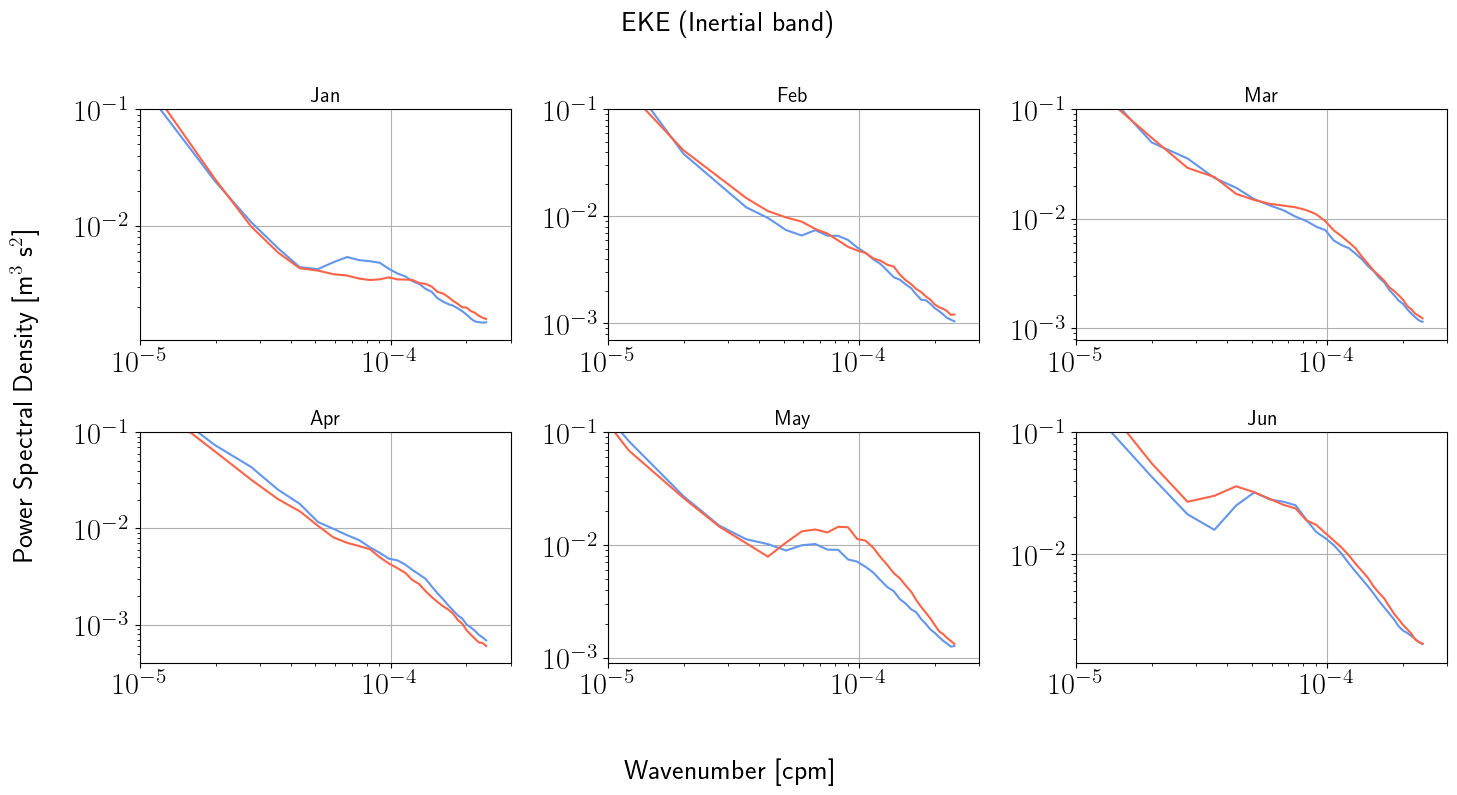

In [217]:
fig, ax = plt.subplots(2,3,figsize=(15,8))

ax=np.ravel(ax)
for i in range(6):

    EKE_FULL_band=(EKE_FULL_table[i]).real.sel(freq_time_counter=slice(1.4e-5,1.7e-5))
    EKE_SMTH_band=(EKE_SMTH_table[i]).real.sel(freq_time_counter=slice(1.4e-5,1.7e-5))
    

    ax[i].plot(EKE_FULL_band.freq_r/dxx,EKE_FULL_band.mean('freq_time_counter')/dxx,label='FULL',color='cornflowerblue')
    ax[i].plot(EKE_SMTH_band.freq_r/dxx,EKE_SMTH_band.mean('freq_time_counter')/dxx,label='SMTH',color='tomato')

    # xmin=1e-6;xmax=3e-4
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlim(1e-5,xmax)
    ax[i].set_ylim(0,1e-1)
    ax[i].set_title('{0}'.format(monstr[i]),fontsize=15)
    ax[i].grid()
    # ax[1].set_ylim(1e-10,0.6e-9)



fig.suptitle('EKE (Inertial band)',fontsize=20)
fig.supylabel(r'Power Spectral Density [m$^3$ s$^2$] ',fontsize=20)
fig.supxlabel(r'Wavenumber [cpm]',fontsize=20)

plt.tight_layout()

In [87]:
sigma_FULL_table=[]
sigma_SMTH_table=[]

for month_x in range(6):

    sigma_full_m=sigma_full[sigma_full.time_counter.dt.month==month_x+1]
    sigma_smth_m=sigma_smth[sigma_smth.time_counter.dt.month==month_x+1]

    sigma_full_m_spec=xrft.power_spectrum(sigma_full_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)


    sigma_smth_m_spec=xrft.power_spectrum(sigma_smth_m.drop(['nav_lat', 'nav_lon','time_centered']),
                        dim=['x','y','time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                         window=wdws,window_correction=wdw_cor)

    sigma_iso_full_m=xrft.isotropize(sigma_full_m_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)
    sigma_iso_smth_m=xrft.isotropize(sigma_smth_m_spec,fftdim=['freq_x','freq_y'],nfactor=nf,complx=False)

    
    sigma_FULL_table.append(sigma_iso_full_m)
    sigma_SMTH_table.append(sigma_iso_smth_m)

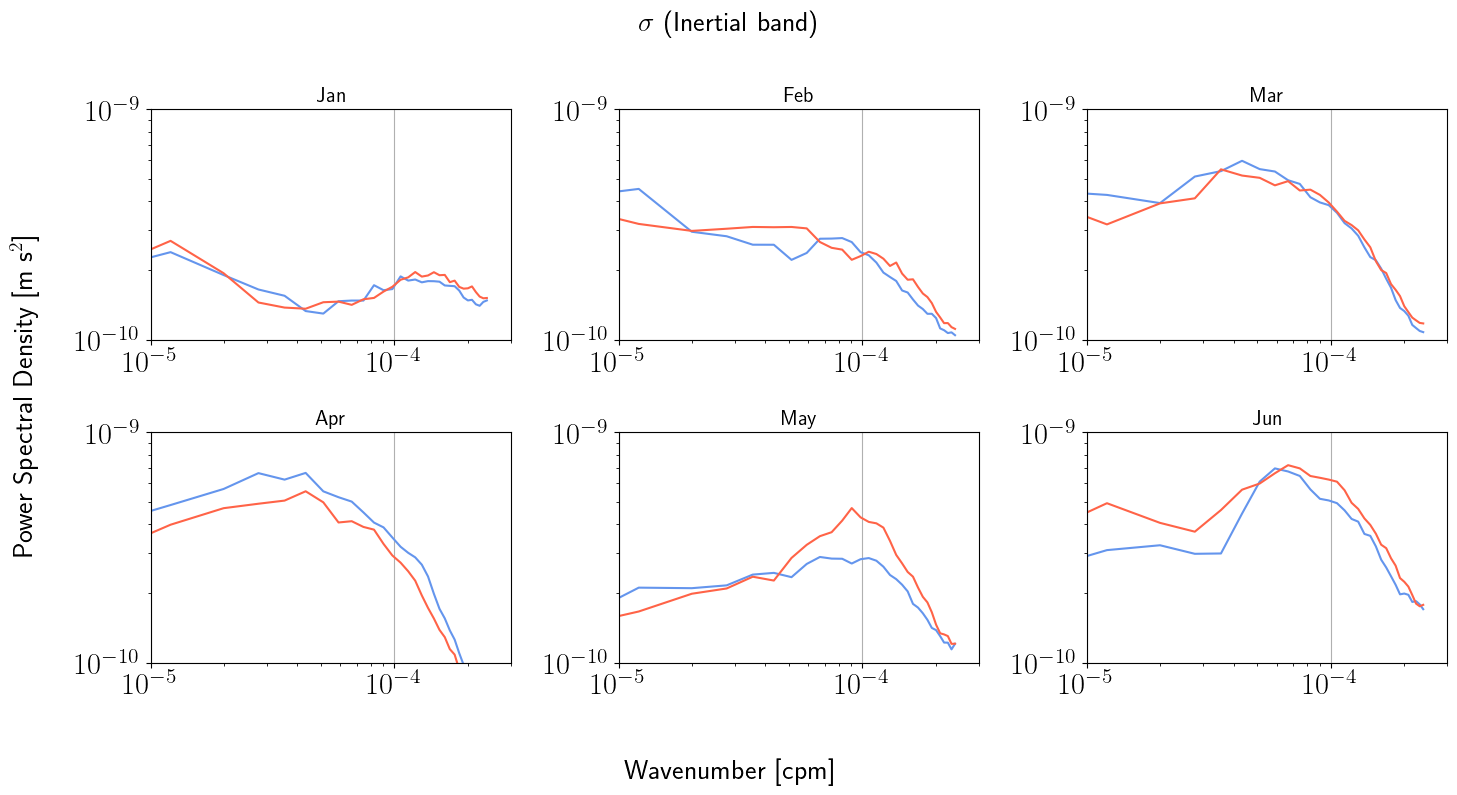

In [93]:
fig, ax = plt.subplots(2,3,figsize=(15,8))

ax=np.ravel(ax)
for i in range(6):

    sigma_FULL_band=(sigma_FULL_table[i]).real.sel(freq_time_counter=slice(1.4e-5,1.7e-5))
    sigma_SMTH_band=(sigma_SMTH_table[i]).real.sel(freq_time_counter=slice(1.4e-5,1.7e-5))

    ax[i].plot(sigma_FULL_band.freq_r/dxx,sigma_FULL_band.mean('freq_time_counter')/dxx,label='FULL',color='cornflowerblue')
    ax[i].plot(sigma_SMTH_band.freq_r/dxx,sigma_SMTH_band.mean('freq_time_counter')/dxx,label='SMTH',color='tomato')

    # xmin=1e-6;xmax=3e-4
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlim(1e-5,xmax)
    ax[i].set_ylim(1e-10,1e-9)
    ax[i].set_title('{0}'.format(monstr[i]),fontsize=15)
    ax[i].grid()



fig.suptitle(r'$\sigma$ (Inertial band)',fontsize=20)
fig.supylabel(r'Power Spectral Density [m s$^2$] ',fontsize=20)
fig.supxlabel(r'Wavenumber [cpm]',fontsize=20)

plt.tight_layout()

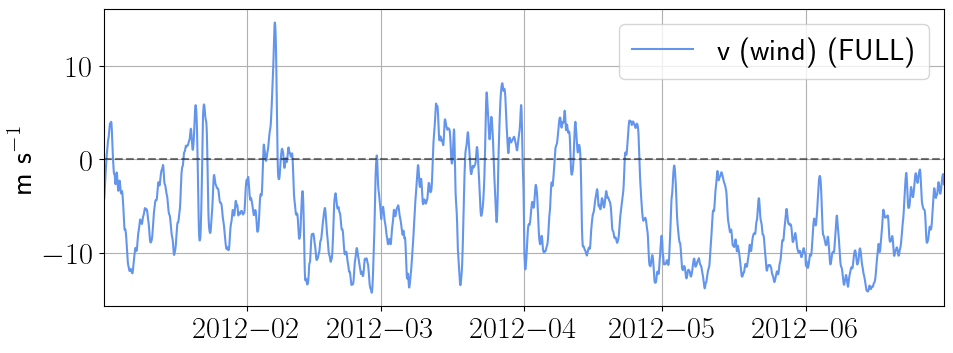

In [239]:
plt.figure(figsize=(10,4))
plt.plot(vwind_full_time.time_counter,(vwind_full_time).mean(['x','y']).rolling(time_counter=3).mean(),color='cornflowerblue',label='v (wind) (FULL)')
# plt.plot(vwind_smth_time.time_counter,(vwind_smth_time).mean(['x','y']).rolling(time_counter=3).mean(),color='navy',label='v (wind) (SMTH)')



plt.legend()
# plt.ylim(-13,13)
plt.hlines(xmin=uwind_full_time.time_counter.min().data,
           xmax=uwind_full_time.time_counter.max().data,y=0,color='k',linestyle='--',alpha=0.5)
plt.xlim(uwind_full_time.time_counter.min().data,uwind_full_time.time_counter.max().data)

plt.grid()
plt.ylabel(r'm s$^{-1}$')
plt.tight_layout()

# Frequency Spectra

In [13]:
sigma_full_freq=xrft.power_spectrum(sigma_full.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

sigma_smth_freq=xrft.power_spectrum(sigma_smth.drop(['nav_lat', 'nav_lon','time_centered']),
                    dim=['time_counter'],scaling=sclstr,true_phase = phase_bol,truncate=truncate_bol, 
                                     window=wdws,window_correction=wdw_cor)

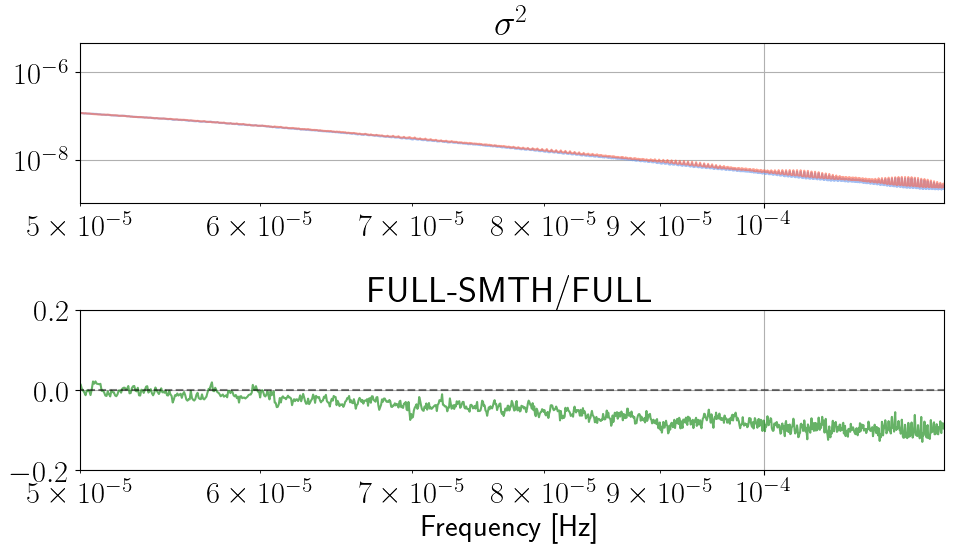

In [109]:
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)


plt.plot(sigma_full_freq.freq_time_counter,sigma_full_freq[:,:,:].mean(['x','y']),
         alpha=0.6,label='FULL',color='cornflowerblue')

plt.plot(sigma_smth_freq.freq_time_counter,sigma_smth_freq[:,:,:].mean(['x','y']),
         alpha=0.6,label='SMTH',color='tomato')




# plt.plot([sw.f(df.nav_lat_rho.mean())/(2*np.pi),sw.f(df.nav_lat_rho.mean())/(2*np.pi)],[1e-9,1e-4],'--')
# # plt.plot([sw.f(df.lat_rho[600,340])/(2*np.pi),sw.f(df.lat_rho[600,340])/(2*np.pi)],[1e-9,1e-4])


plt.grid()
plt.xlim(5e-5,1.2e-4)
# plt.ylim(0.5e-8,2e-7)


plt.xscale('log')
plt.yscale('log')
plt.title(r'$\sigma^{2}$')


plt.subplot(2,1,2)




plt.plot(sigma_full_freq.freq_time_counter,
         (sigma_full_freq[:,:,:].mean(['x','y'])-sigma_smth_freq[:,:,:].mean(['x','y']))/(sigma_full_freq[:,:,:].mean(['x','y'])),
         alpha=0.6,label='FULL',color='green')


plt.xscale('log')
plt.ylim(-0.2,0.2)
plt.plot([sigma_full_freq.freq_time_counter.data.min(),sigma_full_freq.freq_time_counter.data.max()],
         [0,0],'k--',alpha=0.5)

plt.title('FULL-SMTH/FULL')

plt.xlabel(r'Frequency [Hz]')
plt.xlim(5e-5,1.2e-4)
plt.grid()

plt.tight_layout()

# plt.ylim(5e-5,1)

In [58]:
(1/(8e-6))/1000

125.0

In [68]:
((np.sqrt(9.8*50))/(sw.f(varf.nav_lat.mean())))/1000

253.37435566223144

In [63]:
sw.f(varf.nav_lat.mean())

8.736457785288921e-05